In [1]:
# CELL 1 — imports & setup
import csv
from pathlib import Path
from typing import Tuple, Dict, Any, Callable, Optional

import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm

data_dir = Path("./measurements")
print(f"Data resides in: {data_dir.resolve()}")

Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/combine_jax/tfim_torch/measurements


In [2]:
# CELL 2 — parsing & dataloader (PyTorch)

def filestring_to_sample_tensor(filestring: str) -> Tuple[torch.Tensor, torch.Tensor]:
    bit_part, field_part = filestring.strip().split()
    bit_tensor = torch.tensor([int(b) for b in bit_part], dtype=torch.uint8)
    field_tensor = torch.tensor(float(field_part), dtype=torch.float32)
    return bit_tensor, field_tensor


class MixedDataLoader:
    """
    bits:  (N, num_qubits), uint8
    field: (N,),            float32
    """
    def __init__(
            self,
            bits: torch.Tensor,
            field: torch.Tensor,
            batch_size: int = 128,
            shuffle: bool = True,
            drop_last: bool = False,
            gen: Optional[torch.Generator] = None,
    ):
        assert bits.shape[0] == field.shape[0], "Mismatched sample counts"
        self.bits = bits
        self.field = field
        self.dataset_size = bits.shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.gen = torch.Generator().manual_seed(0) if gen is None else gen

        self.slice_boundaries = [
            (i, i + batch_size)
            for i in range(0, self.dataset_size, batch_size)
            if not drop_last or (i + batch_size) <= self.dataset_size
        ]

    def __iter__(self):
        if self.shuffle:
            self.order = torch.randperm(self.dataset_size, generator=self.gen)
        else:
            self.order = torch.arange(self.dataset_size)
        self.slice_idx = 0
        return self

    def __next__(self) -> Tuple[torch.Tensor, torch.Tensor]:
        if self.slice_idx >= len(self.slice_boundaries):
            raise StopIteration
        start, end = self.slice_boundaries[self.slice_idx]
        self.slice_idx += 1
        idxs = self.order[start:end]
        batch_bits = self.bits[idxs]
        batch_field = self.field[idxs]
        return batch_bits, batch_field

    def __len__(self) -> int:
        return len(self.slice_boundaries)


def load_measurements(file_path: Path) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Each non-empty line: '010110 2.0'
    Returns:
      bits:  (N, num_qubits), uint8
      field: (N,),            float32
    """
    with open(file_path, "r") as f:
        lines = [ln.strip() for ln in f if ln.strip()]

    bits_list = []
    field_list = []
    for ln in tqdm(lines, desc=f"Parsing {file_path.name}"):
        b, h = filestring_to_sample_tensor(ln)
        bits_list.append(b)
        field_list.append(h)

    bits = torch.stack(bits_list, dim=0)
    field = torch.stack(field_list, dim=0)
    return bits, field

In [3]:
# CELL 3 — model (PyTorch ConditionalRBM)

class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, width: int):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.fc1 = nn.Linear(1, width)
        self.fc2 = nn.Linear(width, 2 * (num_visible + num_hidden))

    def forward(self, field: torch.Tensor):
        # field: (B,) or (B,1)
        x = field.view(-1, 1) if field.ndim == 1 else field
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        N, H = self.num_visible, self.num_hidden
        gamma_b, beta_b, gamma_c, beta_c = torch.split(x, [N, N, H, H], dim=-1)
        return gamma_b, beta_b, gamma_c, beta_c


class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        nn.init.normal_(self.W, mean=0.0, std=0.01)

        self.conditioner = Conditioner(num_visible, num_hidden, conditioner_width)

    @staticmethod
    def _free_energy(v: torch.Tensor, W: torch.Tensor, b: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        v: (B,N), W: (N,H), b: (B,N) or (N,), c: (B,H) or (H,)
        """
        if b.dim() == 1:
            b = b.unsqueeze(0).expand_as(v)
        h_arg = v @ W
        if c.dim() == 1:
            c = c.unsqueeze(0).expand(h_arg.shape[0], -1)
        term1 = -(v * b).sum(dim=-1)
        term2 = F.softplus(h_arg + c).sum(dim=-1)
        return term1 - term2

    @staticmethod
    def _sample_bernoulli(probs: torch.Tensor, gen: torch.Generator) -> torch.Tensor:
        noise = torch.rand(probs.shape, generator=gen, device=probs.device, dtype=probs.dtype)
        return (noise < probs).to(probs.dtype)

    def _gibbs_step_T(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, T: float, gen: torch.Generator):
        logits_h = (v @ self.W + c_mod) / T
        p_h = torch.sigmoid(logits_h)
        h = self._sample_bernoulli(p_h, gen)

        logits_v = (h @ self.W.t() + b_mod) / T
        p_v = torch.sigmoid(logits_v)
        v = self._sample_bernoulli(p_v, gen)
        return v

    def forward(self, batch: Tuple[torch.Tensor, torch.Tensor], aux_vars: Dict[str, Any]):
        measurement, field = batch
        gen: torch.Generator = aux_vars.get("gen", torch.Generator().manual_seed(0))
        l2_strength: float = float(aux_vars.get("l2_strength", 0.0))

        v_data = measurement.float()

        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(field)
        b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
        c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c

        v_model = (torch.rand(v_data.shape, generator=gen, device=v_data.device) < 0.5).float()
        for _ in range(self.k):
            v_model = self._gibbs_step_T(v_model, b_mod, c_mod, self.T, gen)
        v_model = v_model.detach()

        fe_data = self._free_energy(v_data, self.W, b_mod, c_mod)
        fe_model = self._free_energy(v_model, self.W, b_mod, c_mod)

        fe_delta = fe_data - fe_model
        fe_mean = fe_delta.mean()
        fe_std = fe_delta.std(unbiased=False)

        l2_regularization = ((self.b.unsqueeze(0) - b_mod) ** 2).sum() + ((self.c.unsqueeze(0) - c_mod) ** 2).sum()
        loss = fe_mean + l2_strength * l2_regularization

        aux_out = {
            "free_energy_mean": fe_mean.detach(),
            "free_energy_std": fe_std.detach(),
        }
        return loss, aux_out

    @torch.no_grad()
    def generate(self, field: torch.Tensor, T_schedule: torch.Tensor, gen: torch.Generator):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(field)
        b_mod = (1 + gamma_b) * self.b.unsqueeze(0) + beta_b
        c_mod = (1 + gamma_c) * self.c.unsqueeze(0) + beta_c

        B = field.shape[0]
        v = (torch.rand((B, self.num_visible), generator=gen, device=field.device) < 0.5).float()
        for i in range(int(T_schedule.shape[0])):
            T_i = float(T_schedule[i].item()) if T_schedule.ndim > 0 else float(T_schedule)
            v = self._gibbs_step_T(v, b_mod, c_mod, T_i, gen)
        return v

In [4]:
# CELL 4 — training utilities (scheduler/loop)

def train_step(
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        batch: Tuple[torch.Tensor, torch.Tensor],
        aux_vars: Dict[str, Any],
):
    optimizer.zero_grad(set_to_none=True)
    loss, aux = model(batch, aux_vars)
    loss.backward()
    optimizer.step()
    return loss.detach(), aux


def train(
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        loader: MixedDataLoader,
        num_epochs: int,
        gen: torch.Generator,
        l2_strength: float,
        lr_schedule_fn: Callable[[int], float],
):
    metrics: Dict[int, Any] = {}
    global_step = 0

    for epoch in range(num_epochs):
        tot_loss = 0.0
        fe_mean_last = torch.tensor(0.0)
        fe_std_last = torch.tensor(0.0)

        for batch_bits, batch_field in loader:
            lr = float(lr_schedule_fn(global_step))
            for g in optimizer.param_groups:
                g["lr"] = lr

            aux_vars = {"gen": gen, "l2_strength": l2_strength}
            loss, aux_out = train_step(model, optimizer, (batch_bits, batch_field), aux_vars)

            tot_loss += float(loss)
            fe_mean_last = aux_out["free_energy_mean"]
            fe_std_last = aux_out["free_energy_std"]
            global_step += 1

        avg_loss = tot_loss / len(loader)
        lr_epoch = float(lr_schedule_fn(global_step))

        metrics[epoch] = dict(
            loss=avg_loss,
            free_energy_mean=float(fe_mean_last),
            free_energy_var=float(fe_std_last),
            lr=lr_epoch,
        )

        print(
            f"Epoch {epoch + 1}/{num_epochs} | "
            f"Loss: {avg_loss:+.4f} | "
            f"Free En. Mean: {float(fe_mean_last):.4f} | "
            f"Free En. STD: {float(fe_std_last):.4f} | "
            f"Learning Rate: {lr_epoch:.5f}"
        )

    return model, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2.0
    def curve_fn(step: int) -> float:
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center_step))))
    return curve_fn


In [5]:
# CELL 5 — load dataset & concat

file_names = [
    "tfim_h1.00_3x3_10000.txt",
    "tfim_h2.00_3x3_10000.txt",
    "tfim_h2.80_3x3_10000.txt",
    "tfim_h3.00_3x3_10000.txt",
    "tfim_h3.30_3x3_10000.txt",
    "tfim_h3.60_3x3_10000.txt",
    "tfim_h4.00_3x3_10000.txt",
    "tfim_h5.00_3x3_10000.txt",
    "tfim_h6.00_3x3_10000.txt",
    "tfim_h7.00_3x3_10000.txt",
]

bits_list, fields_list = [], []
for fn in file_names:
    bits_i, field_i = load_measurements(data_dir / fn)
    bits_list.append(bits_i)     # (N, num_qubits) uint8
    fields_list.append(field_i)  # (N,)          float32

bits = torch.cat(bits_list, dim=0)       # (total, num_qubits)
fields = torch.cat(fields_list, dim=0)   # (total,)


Parsing tfim_h7.00_3x3_10000.txt: 100%|██████████| 10000/10000 [00:00<00:00, 138665.22it/s]


In [6]:
# CELL 6 — hyperparams, model/optim, loader, training

batch_size        = 1024
num_visible       = int(bits.shape[1])
num_hidden        = 9
conditioner_width = 32
num_epochs        = 100
k_steps           = 100
init_lr           = 1e-2
final_lr          = init_lr * 0.1
l2_strength       = 0.0

gen = torch.Generator().manual_seed(0)

model = ConditionalRBM(
    num_visible=num_visible,
    num_hidden=num_hidden,
    conditioner_width=conditioner_width,
    k=k_steps,
    T=1.0,
)

optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
loader = MixedDataLoader(bits=bits, field=fields, batch_size=batch_size, gen=gen)

schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)

model, metrics = train(model, optimizer, loader, num_epochs, gen, l2_strength, lr_schedule_fn)


Epoch 1/100 | Loss: -0.0142 | Free En. Mean: -0.2909 | Free En. STD: 0.7428 | Learning Rate: 0.00925
Epoch 2/100 | Loss: -0.2412 | Free En. Mean: -0.2564 | Free En. STD: 1.9584 | Learning Rate: 0.00922
Epoch 3/100 | Loss: -0.0921 | Free En. Mean: -0.0228 | Free En. STD: 1.8222 | Learning Rate: 0.00918
Epoch 4/100 | Loss: -0.0611 | Free En. Mean: 0.0864 | Free En. STD: 1.9477 | Learning Rate: 0.00914
Epoch 5/100 | Loss: -0.0360 | Free En. Mean: -0.1698 | Free En. STD: 1.9171 | Learning Rate: 0.00911
Epoch 6/100 | Loss: -0.0216 | Free En. Mean: -0.0891 | Free En. STD: 1.9431 | Learning Rate: 0.00907
Epoch 7/100 | Loss: -0.0112 | Free En. Mean: -0.0419 | Free En. STD: 1.8477 | Learning Rate: 0.00902
Epoch 8/100 | Loss: -0.0003 | Free En. Mean: -0.0126 | Free En. STD: 1.9223 | Learning Rate: 0.00898
Epoch 9/100 | Loss: +0.0038 | Free En. Mean: 0.1426 | Free En. STD: 2.0907 | Learning Rate: 0.00894
Epoch 10/100 | Loss: +0.0040 | Free En. Mean: 0.0809 | Free En. STD: 1.9140 | Learning Rate: 

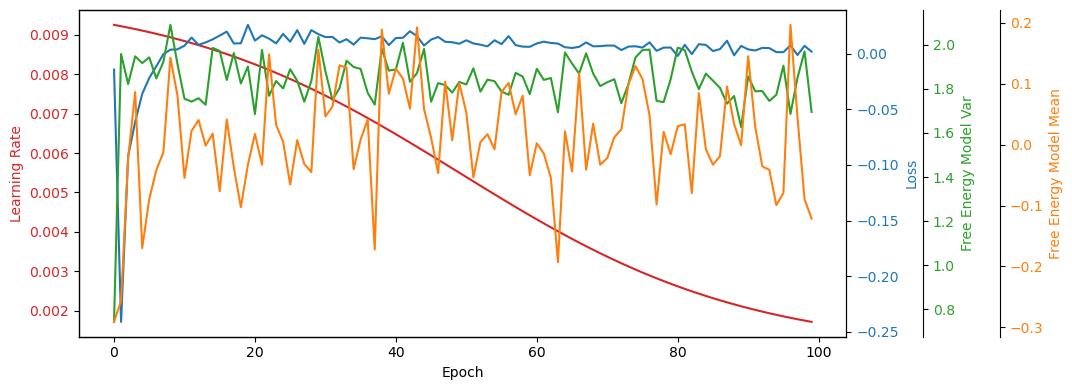

In [7]:
# CELL 7 — plotting (kept same)

epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
free_model_mean_vals = [metrics[e]['free_energy_mean'] for e in epochs]
free_model_var_vals = [metrics[e]['free_energy_var'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots(figsize=(11, 4))

ax1.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Learning Rate", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.00))
ax2.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax2.set_ylabel("Loss", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
ax3.plot(epochs, free_model_var_vals, label="Free Energy Model Var", color="tab:green")
ax3.set_ylabel("Free Energy Model Var", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.2))
ax4.plot(epochs, free_model_mean_vals, label="Free Energy Model Mean", color="tab:orange")
ax4.set_ylabel("Free Energy Model Mean", color="tab:orange")
ax4.tick_params(axis="y", labelcolor="tab:orange")

plt.tight_layout()
plt.show()


In [8]:
# CELL 8 — physics metrics: magnetizations + helpers (PyTorch)

def magnetization_z_with_error(samples: torch.Tensor):
    """
    samples: (B,N) with entries in {0,1}
    returns mean |m_z| and SEM
    """
    samples = samples.float()
    spins = 1.0 - 2.0 * samples              # {0,1} -> {+1,-1}
    sample_mags = spins.mean(dim=1).abs()    # (B,)
    mean_mag = sample_mags.mean()
    # ddof=1 equivalent:
    sem_mag = sample_mags.std(unbiased=True) / math.sqrt(sample_mags.numel())
    return mean_mag, sem_mag


def _free_energy_batch(v_batch: torch.Tensor, W: torch.Tensor,
                       b_batch: torch.Tensor, c_batch: torch.Tensor) -> torch.Tensor:
    """
    v_batch: (B,N), W: (N,H), b_batch: (B,N), c_batch: (B,H)
    returns: (B,)
    """
    vb_term = (v_batch * b_batch).sum(dim=-1)
    hidden_term = F.softplus(v_batch @ W + c_batch).sum(dim=-1)
    return -vb_term - hidden_term


@torch.no_grad()
def amplitude_ratio_flip(model: "ConditionalRBM",
                         samples: torch.Tensor, field: torch.Tensor, flip_idx: int) -> torch.Tensor:
    """
    exp(0.5*(F_ref - F_flip)) per sample, flipping bit at flip_idx
    """
    samples = samples.float()
    samples_flip = samples.clone()
    samples_flip[:, flip_idx] = 1.0 - samples_flip[:, flip_idx]

    gamma_b, beta_b, gamma_c, beta_c = model.conditioner(field)
    b_mod = (1.0 + gamma_b) * model.b.unsqueeze(0) + beta_b
    c_mod = (1.0 + gamma_c) * model.c.unsqueeze(0) + beta_c
    W = model.W

    F_ref  = _free_energy_batch(samples,      W, b_mod, c_mod)
    F_flip = _free_energy_batch(samples_flip, W, b_mod, c_mod)
    return torch.exp(0.5 * (F_ref - F_flip))


@torch.no_grad()
def magnetization_x_with_error(model: "ConditionalRBM",
                               samples: torch.Tensor, field: torch.Tensor) -> Tuple[float, float]:
    """
    Per-sample ⟨σ_x⟩ ≈ mean over single-site amplitude ratios
    """
    num_qubits = samples.shape[1]
    ratios = []
    for i in range(num_qubits):
        ratios.append(amplitude_ratio_flip(model, samples, field, i))
    all_ratios = torch.stack(ratios, dim=1)  # (B, N)
    per_sample_mx = all_ratios.mean(dim=1)   # (B,)
    mean = per_sample_mx.mean()
    sem  = per_sample_mx.std(unbiased=True) / math.sqrt(per_sample_mx.numel())
    return float(mean), float(sem)

In [9]:
# CELL 9 — sampling helper

@torch.no_grad()
def sample_from_model(model: ConditionalRBM, h: float, n: int, gen: torch.Generator):
    field = torch.full((n,), float(h), dtype=torch.float32)
    sampling_steps = int(model.k)
    T_schedule = torch.full((sampling_steps,), float(model.T), dtype=torch.float32)
    samples = model.generate(field, T_schedule, gen)
    return samples.float(), field


In [10]:
# CELL 10 — evaluation sweep & CSV

support_h = [1.0, 2.0, 2.8, 3.0, 3.3, 3.6, 4.0, 5.0, 6.0, 7.0]
novel_h   = [1.5, 2.4, 2.6, 2.9, 3.1, 3.2, 3.4, 3.8, 4.5, 5.5, 6.5]
sweep = sorted([(h, "support") for h in support_h] + [(h, "novel") for h in novel_h], key=lambda x: x[0])

csv_file = Path("magnetization.csv")
if not csv_file.exists() or csv_file.stat().st_size == 0:
    with csv_file.open("w", newline="") as f:
        csv.writer(f).writerow(["h", "type", "mag_z", "mag_z_error", "mag_x", "mag_x_error"])

num_samples = 10_000
gen_eval = torch.Generator().manual_seed(1234)

for h, origin in sweep:
    samples, field = sample_from_model(model, h, num_samples, gen_eval)

    mz, mz_e = magnetization_z_with_error(samples)
    mx, mx_e = magnetization_x_with_error(model, samples, field)

    print(f"h={h:4.1f} [{origin:6}] m_z={float(mz):.6f}±{float(mz_e):.6f}  "
          f"m_x={float(mx):.6f}±{float(mx_e):.6f}")

    with csv_file.open("a", newline="") as f:
        csv.writer(f).writerow([
            f"{h:.6f}", origin,
            f"{float(mz):.6f}", f"{float(mz_e):.6f}",
            f"{float(mx):.6f}", f"{float(mx_e):.6f}"
        ])

print(f"\nAppended rows to {csv_file.resolve()}")

h= 1.0 [support] m_z=0.967755±0.000877  m_x=0.249638±0.003333
h= 1.5 [novel ] m_z=0.938933±0.001347  m_x=0.332447±0.003527
h= 2.0 [support] m_z=0.822622±0.002248  m_x=0.561066±0.003366
h= 2.4 [novel ] m_z=0.701267±0.002808  m_x=0.714696±0.003138
h= 2.6 [novel ] m_z=0.631333±0.002964  m_x=0.786246±0.002883
h= 2.8 [support] m_z=0.575289±0.002996  m_x=0.837437±0.002613
h= 2.9 [novel ] m_z=0.550600±0.002954  m_x=0.859979±0.002428
h= 3.0 [support] m_z=0.516289±0.002971  m_x=0.885085±0.002290
h= 3.1 [novel ] m_z=0.510156±0.002936  m_x=0.890995±0.002170
h= 3.2 [novel ] m_z=0.489844±0.002884  m_x=0.906358±0.002033
h= 3.3 [support] m_z=0.475422±0.002824  m_x=0.917533±0.001897
h= 3.4 [novel ] m_z=0.460711±0.002814  m_x=0.926436±0.001815
h= 3.6 [support] m_z=0.439489±0.002743  m_x=0.940121±0.001630
h= 3.8 [novel ] m_z=0.418556±0.002728  m_x=0.950393±0.001519
h= 4.0 [support] m_z=0.403667±0.002653  m_x=0.959237±0.001377
h= 4.5 [novel ] m_z=0.379289±0.002565  m_x=0.970792±0.001152
h= 5.0 [support] 